# Syrah Tasting - Data Cleansing

In [1]:
# the following notebook analyzes the MBS2A-TU14 Syrah Tasting performed on 29 January 2021 
# Sean Kacur, 2 February 2021

In [2]:
# load packages
import numpy as np  # array maniuplation
import pandas as pd  # dataframe mangagement
from scipy import stats  # to assist with statistical analysis
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
import matplotlib.pyplot as plt  # visualization
import seaborn as sns  # visual aesthetics
import ipystata  # to call stata from the notebook
%matplotlib inline

IPyStata is loaded in batch mode.


In [3]:
# load data
Nose_df = pd.read_csv('Syrah_Nose.csv')  # name and read in the Syrah_Nose csv
Palate_df = pd.read_csv('Syrah_Palate.csv')
Nose_df.head()  # to display the first 5 rows of data

,Taster,Wine,Country,Price,Ethanol,Gluc_Fruc,TA,pH,AV,Malic_Acid,...,tree_moss,truffle,mushroom,Wine_Faults,Cork_Taint,Reduction,Heat,VA,Sulfites,Brett
0,1,792,Morocco,15.50€,13.44,0.5,3.28,3.66,0.44,0.0,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,580,New Zealand,21.70€,12.67,0.5,3.70,3.62,0.61,0.0,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
2,1,189,Thailand,23.30€,12.49,0.0,3.57,3.77,0.59,0.0,...,NaN,NaN,NaN,1,NaN,1.0,NaN,NaN,NaN,NaN
3,1,821,Italy,32.00€,13.75,0.0,3.40,3.69,0.54,0.0,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
4,1,961,France,40.00€,12.97,0.5,2.99,3.79,0.55,0.0,...,NaN,NaN,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN


# Clean the Data

In [4]:
Nose_df.info()  # first we need to check the things that need to be cleaned

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Taster           152 non-null    int64  
 1   Wine             152 non-null    int64  
 2   Country          152 non-null    object 
 3   Price            152 non-null    object 
 4   Ethanol          152 non-null    float64
 5   Gluc_Fruc        152 non-null    float64
 6   TA               152 non-null    float64
 7   pH               152 non-null    float64
 8   AV               152 non-null    float64
 9   Malic_Acid       152 non-null    float64
 10  Lactic_Acid      152 non-null    float64
 11  IPT              152 non-null    int64  
 12  Density          152 non-null    float64
 13  Rank             150 non-null    float64
 14  Country_Guess    152 non-null    object 
 15  Correct_Guess    80 non-null     object 
 16  Nose_Count       152 non-null    int64  
 17  Fruity          

In [5]:
# let's start by filling  in the Country_Guess column
# we can use np.where to compare values between two columns and specify what string to put into a third column
Nose_df['Correct_Guess'] = np.where(Nose_df['Country'] == Nose_df['Country_Guess'], 'True', 'False')
Palate_df['Correct_Guess'] = np.where(Palate_df['Country'] == Palate_df['Country_Guess'], 'True', 'False')
Nose_df['Correct_Guess'].head()  # to check our work

0    False
1     True
2    False
3     True
4     True
Name: Correct_Guess, dtype: object

In [6]:
# how many correct guesses were there?
correct = Nose_df.Correct_Guess.value_counts()['True']  # name variable correct based on all conditions where True
incorrect = Nose_df.Correct_Guess.value_counts()['False']
print(correct/incorrect*100)  # divide correct by incorrect and print

40.74074074074074


In [7]:
# now let's replace all Nan values with 0, this will help our future statistical tests to run smoothly
Nose_df = Nose_df.replace(np.nan, 0)  # use numpy replace and specify to exchane Nan with 0
Palate_df = Palate_df.replace(np.nan, 0)  # in order to save the change we have to rename the dataframe
Nose_df.head()                            # use the same name in order to save memory

,Taster,Wine,Country,Price,Ethanol,Gluc_Fruc,TA,pH,AV,Malic_Acid,...,tree_moss,truffle,mushroom,Wine_Faults,Cork_Taint,Reduction,Heat,VA,Sulfites,Brett
0,1,792,Morocco,15.50€,13.44,0.5,3.28,3.66,0.44,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,580,New Zealand,21.70€,12.67,0.5,3.70,3.62,0.61,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,189,Thailand,23.30€,12.49,0.0,3.57,3.77,0.59,0.0,...,0.0,0.0,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0
3,1,821,Italy,32.00€,13.75,0.0,3.40,3.69,0.54,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,961,France,40.00€,12.97,0.5,2.99,3.79,0.55,0.0,...,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# we actually want the Rank column to contain Nan because a 0 will throw off the rankings
Nose_df['Rank'] = Nose_df['Rank'].replace(0, np.nan)
Palate_df['Rank'] = Palate_df['Rank'].replace(0, np.nan) 

In [9]:
Nose_df.info()  # to see what work we have left

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Taster           152 non-null    int64  
 1   Wine             152 non-null    int64  
 2   Country          152 non-null    object 
 3   Price            152 non-null    object 
 4   Ethanol          152 non-null    float64
 5   Gluc_Fruc        152 non-null    float64
 6   TA               152 non-null    float64
 7   pH               152 non-null    float64
 8   AV               152 non-null    float64
 9   Malic_Acid       152 non-null    float64
 10  Lactic_Acid      152 non-null    float64
 11  IPT              152 non-null    int64  
 12  Density          152 non-null    float64
 13  Rank             150 non-null    float64
 14  Country_Guess    152 non-null    object 
 15  Correct_Guess    152 non-null    object 
 16  Nose_Count       152 non-null    int64  
 17  Fruity          

In [10]:
# in the Price column the euro symbol doesn't allow pandas to recognize the values as integers
# we can use pandas string functions to replace the euro symbol with nothing
Nose_df['Price'] = Nose_df['Price'].str.replace('€', '').astype('float64')  # set type to float to make price an int
Palate_df['Price'] = Palate_df['Price'].str.replace('€','').astype('float64')
Nose_df.head()  

,Taster,Wine,Country,Price,Ethanol,Gluc_Fruc,TA,pH,AV,Malic_Acid,...,tree_moss,truffle,mushroom,Wine_Faults,Cork_Taint,Reduction,Heat,VA,Sulfites,Brett
0,1,792,Morocco,15.5,13.44,0.5,3.28,3.66,0.44,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,580,New Zealand,21.7,12.67,0.5,3.70,3.62,0.61,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,189,Thailand,23.3,12.49,0.0,3.57,3.77,0.59,0.0,...,0.0,0.0,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0
3,1,821,Italy,32.0,13.75,0.0,3.40,3.69,0.54,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,961,France,40.0,12.97,0.5,2.99,3.79,0.55,0.0,...,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# write the cleaned df to excel so that it can be shared 
'''Nose_df.to_excel("Syrah_Nose_cleaned.xlsx",
             sheet_name='Nose') 
Palate_df.to_excel("Syrah_Palate_cleaned.xlsx",
                  sheet_name='Palate')'''

'Nose_df.to_excel("Syrah_Nose_cleaned.xlsx",\n             sheet_name=\'Nose\') \nPalate_df.to_excel("Syrah_Palate_cleaned.xlsx",\n                  sheet_name=\'Palate\')'

# Statistics

In [12]:
Nose_df['Nose_Count'].describe()

count    152.000000
mean       3.888158
std        1.709147
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       10.000000
Name: Nose_Count, dtype: float64

In [13]:
Palate_df['Palate_Count'].describe()

count    152.000000
mean       3.078947
std        1.476197
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        7.000000
Name: Palate_Count, dtype: float64

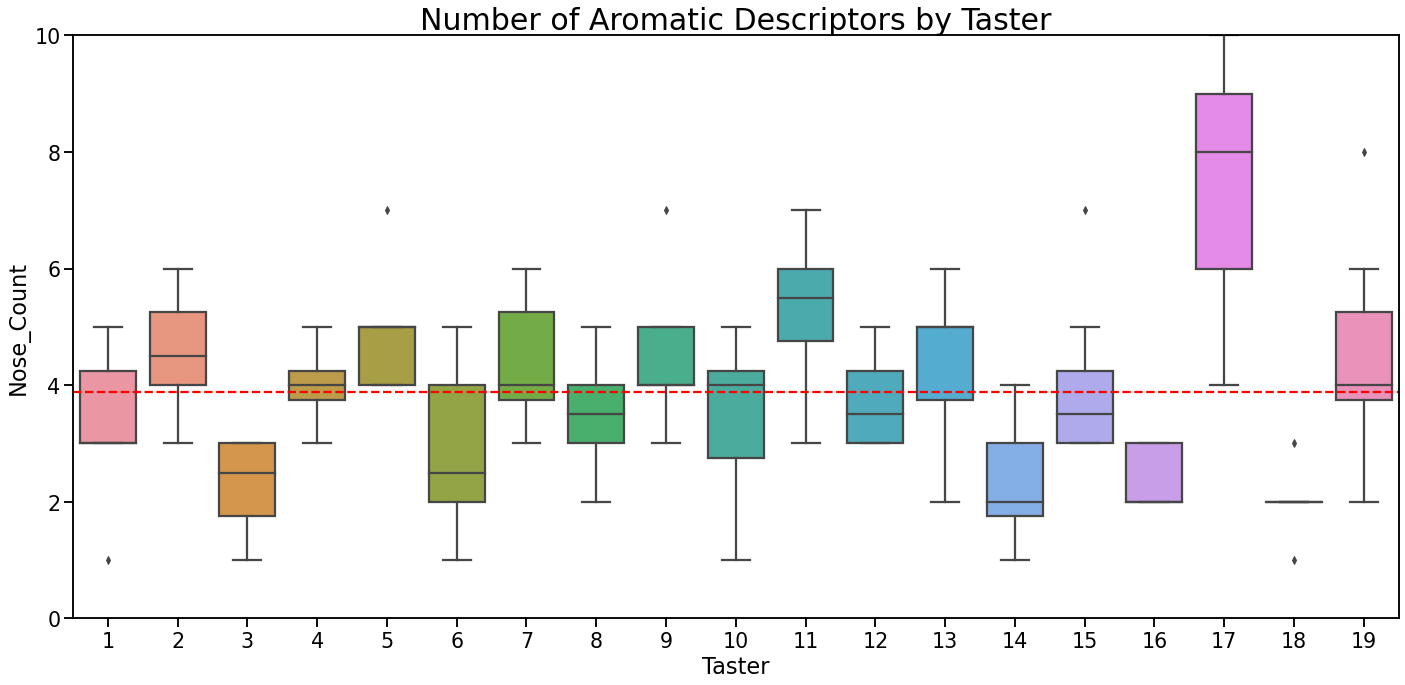

In [14]:
# let's start with a simple box plot to see how many words each taster used to describe aromatic characteristics
sns.set_context("talk", font_scale=1.25)  # set up our aesthetics
fig, ax = plt.subplots(figsize=(20,10))  # and set the figure size
ax.set(ylim=(0, 10))  # set the ylim to the same thing for both plots -- makes comparison easier
plt.title('Number of Aromatic Descriptors by Taster', fontsize='30')  # always a title
sns.boxplot(x=Nose_df['Taster'], y=Nose_df['Nose_Count'])
ax.axhline(3.88, ls='--', color='red')  # insert a line at 3.88 for the mean
plt.tight_layout()

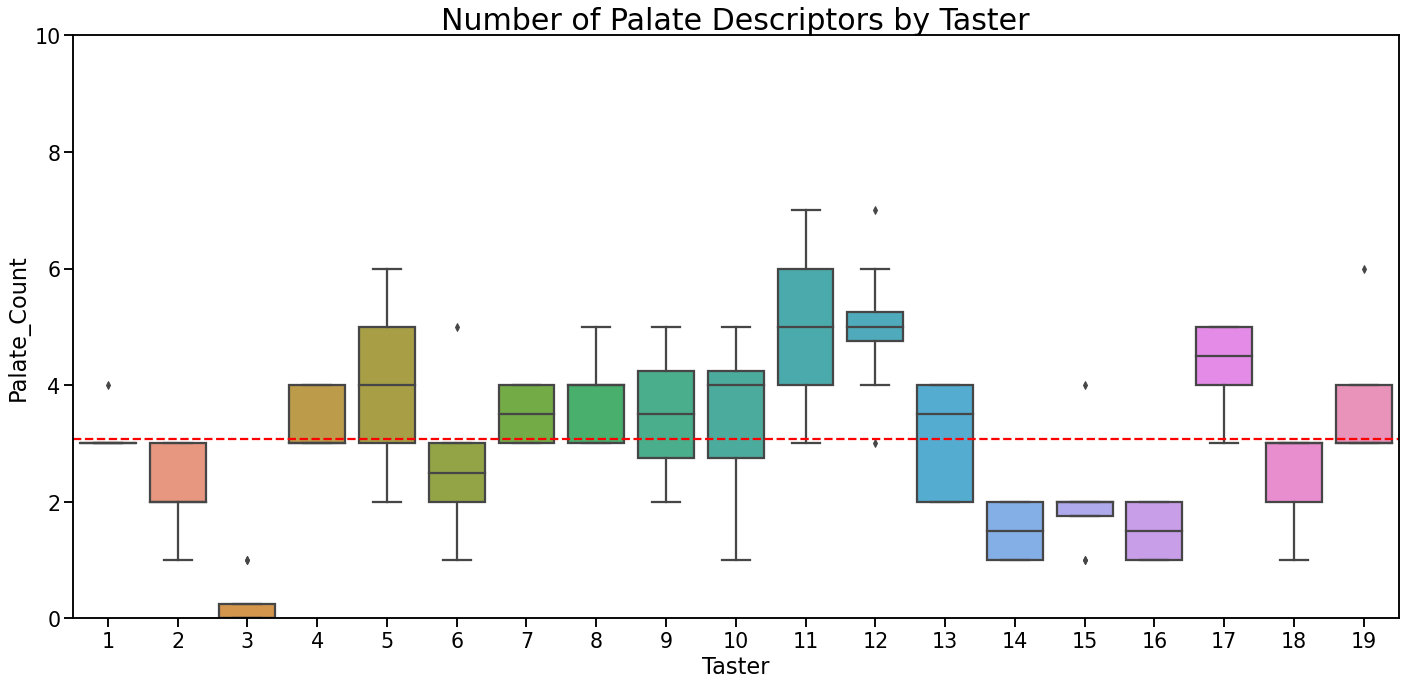

In [15]:
# let's start with a simple box plot to see how many words each taster used to describe aromatic characteristics
sns.set_context("talk", font_scale=1.25)  # set up our aesthetics
fig, ax = plt.subplots(figsize=(20,10))  # and set the figure size
ax.set(ylim=(0, 10))  # set the ylim to the same thing for both plots -- makes comparison easier
plt.title('Number of Palate Descriptors by Taster', fontsize='30')  # always a title
sns.boxplot(x=Palate_df['Taster'], y=Palate_df['Palate_Count'])
ax.axhline(3.07, ls='--', color='red')  # insert a line at 3.0 for the mean
plt.tight_layout()

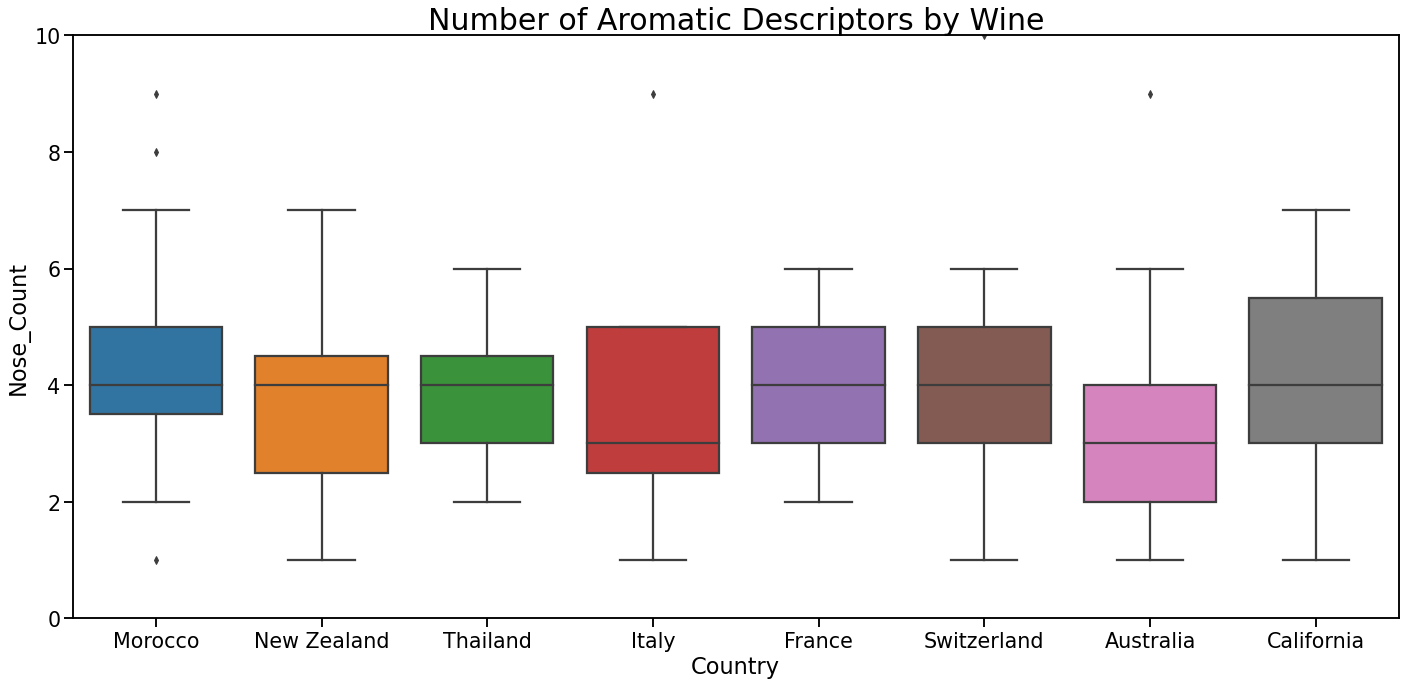

In [16]:
# now I would like to see the same but by wine
sns.set_context("talk", font_scale=1.25)  # set up our aesthetics
fig, ax = plt.subplots(figsize=(20,10))  # and set the figure size
plt.title('Number of Aromatic Descriptors by Wine', fontsize='30')  # always a title
ax.set(ylim=(0, 10))  # set the ylim to the same thing for both plots -- makes comparison easier
sns.boxplot(x=Nose_df['Country'], y=Nose_df['Nose_Count'])
plt.tight_layout()

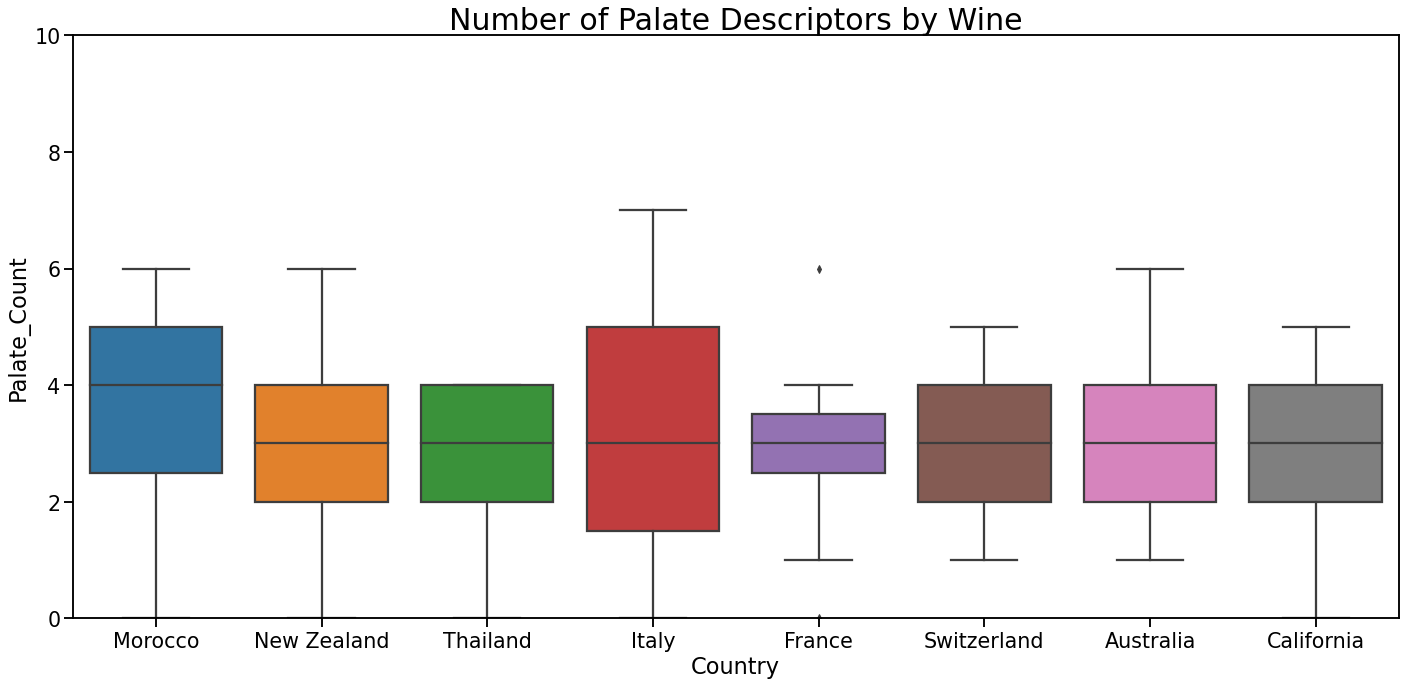

In [17]:
# now I would like to see the same but by wine
sns.set_context("talk", font_scale=1.25)  # set up our aesthetics
fig, ax = plt.subplots(figsize=(20,10))  # and set the figure size
ax.set(ylim=(0, 10))  # set the ylim to the same thing for both plots -- makes comparison easier
plt.title('Number of Palate Descriptors by Wine', fontsize='30')  # always a title
sns.boxplot(x=Palate_df['Country'], y=Palate_df['Palate_Count'])
plt.tight_layout()

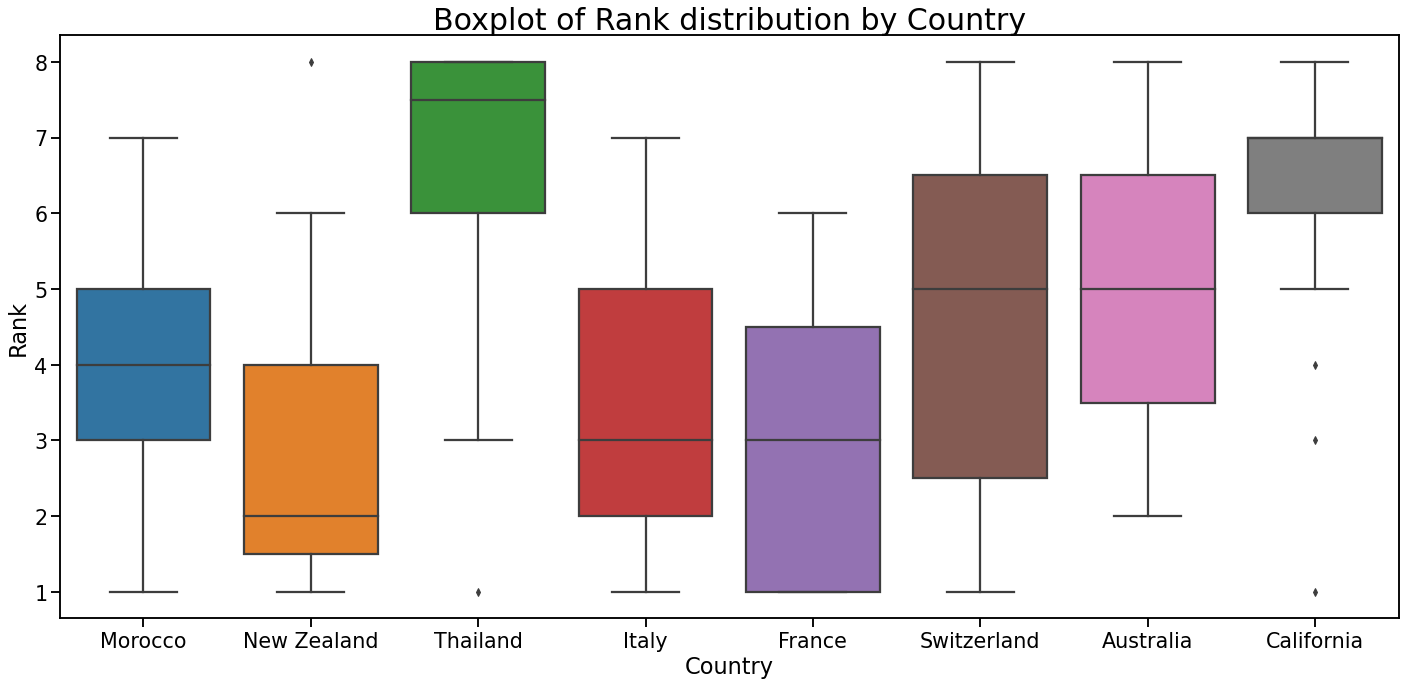

In [18]:
# now I would like to see the same but by wine
sns.set_context("talk", font_scale=1.25)  # set up our aesthetics
fig, ax = plt.subplots(figsize=(20,10))  # and set the figure size
plt.title('Boxplot of Rank distribution by Country', fontsize='30')  # always a title
sns.boxplot(x=Nose_df['Country'], y=Nose_df['Rank'])
plt.tight_layout()

In [19]:
# we are going to make a subgroup of our Nose data frame so that we can look at statistics by country
df_Country = Nose_df.groupby('Country').mean()  # we compile the mean values into this dataset

In [20]:
df_Country.head()

,Taster,Wine,Price,Ethanol,Gluc_Fruc,TA,pH,AV,Malic_Acid,Lactic_Acid,...,tree_moss,truffle,mushroom,Wine_Faults,Cork_Taint,Reduction,Heat,VA,Sulfites,Brett
Country,,,,,,,,,,,,,,,,,,,,,
Australia,10.0,373.0,19.7,13.56,0.2,3.54,3.60,0.51,0.1,1.4,...,0.0,0.052632,0.000000,0.157895,0.0,0.052632,0.0,0.052632,0.052632,0.000000
California,10.0,453.0,37.8,13.09,0.0,2.89,3.88,0.49,0.0,2.4,...,0.0,0.052632,0.105263,0.368421,0.0,0.105263,0.0,0.000000,0.052632,0.105263
France,10.0,961.0,40.0,12.97,0.5,2.99,3.79,0.55,0.0,1.7,...,0.0,0.000000,0.105263,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
Italy,10.0,821.0,32.0,13.75,0.0,3.40,3.69,0.54,0.0,2.6,...,0.0,0.000000,0.105263,0.052632,0.0,0.000000,0.0,0.052632,0.000000,0.000000
Morocco,10.0,792.0,15.5,13.44,0.5,3.28,3.66,0.44,0.0,1.1,...,0.0,0.052632,0.052632,0.052632,0.0,0.000000,0.0,0.052632,0.000000,0.000000


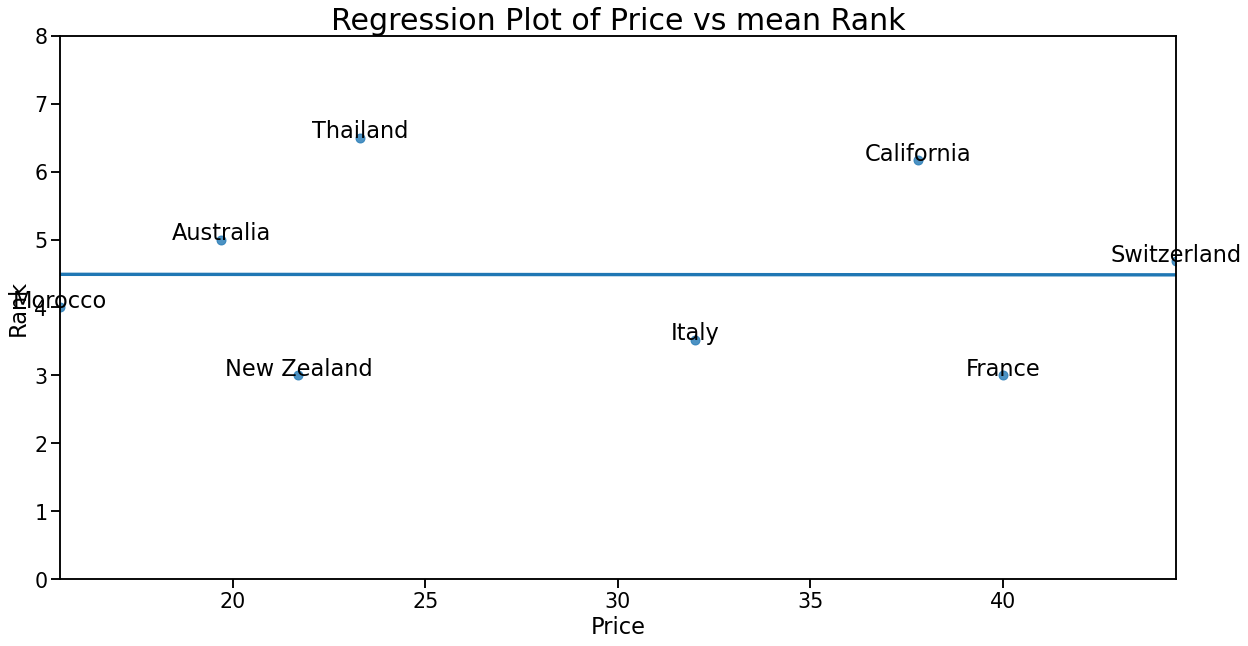

In [21]:
# now we can make a regression plot of Wine Price vs mean Rank
sns.set_context("talk", font_scale=1.25)  # set up our aesthetics
fig, ax = plt.subplots(figsize=(20,10))  # and set the figure size
ax.set(ylim=(0, 8))  # set the ylim to the same thing for both plots -- makes comparison easier
plt.title('Regression Plot of Price vs mean Rank', fontsize='30')  # always a title
sns.regplot(x=df_Country['Price'], y=df_Country['Rank'], ci=None)
for line in range(0,df_Country.shape[0]):
     ax.text(df_Country.Price[line], df_Country.Rank[line], df_Country.index[line], horizontalalignment='center', size='medium', color='black')

In [22]:
%%stata -d df_Country
reg Rank Price
estimates table, star(.05 .01 .001)


      Source |       SS           df       MS      Number of obs   =         8
-------------+----------------------------------   F(1, 6)         =      0.00
       Model |  .000055418         1  .000055418   Prob > F        =    0.9961
    Residual |  12.7578316         6  2.12630527   R-squared       =    0.0000
-------------+----------------------------------   Adj R-squared   =   -0.1667
       Total |   12.757887         7  1.82255529   Root MSE        =    1.4582

------------------------------------------------------------------------------
        Rank |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       Price |   -.000263   .0515087    -0.01   0.996    -.1263001    .1257742
       _cons |   4.492357    1.59544     2.82   0.031     .5884561    8.396258
------------------------------------------------------------------------------

------------------------------
    Variable |    

In [23]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_Country['Ethanol'], df_Country['Rank'])
print('slope {0:6.2f}, intercept {1:6.2f}'.format(slope,intercept))
print('correlation coefficient {0:6.3f}, p value {1:8.5f}'.format(r_value, p_value))

slope  -0.67, intercept  13.21
correlation coefficient -0.237, p value  0.57186


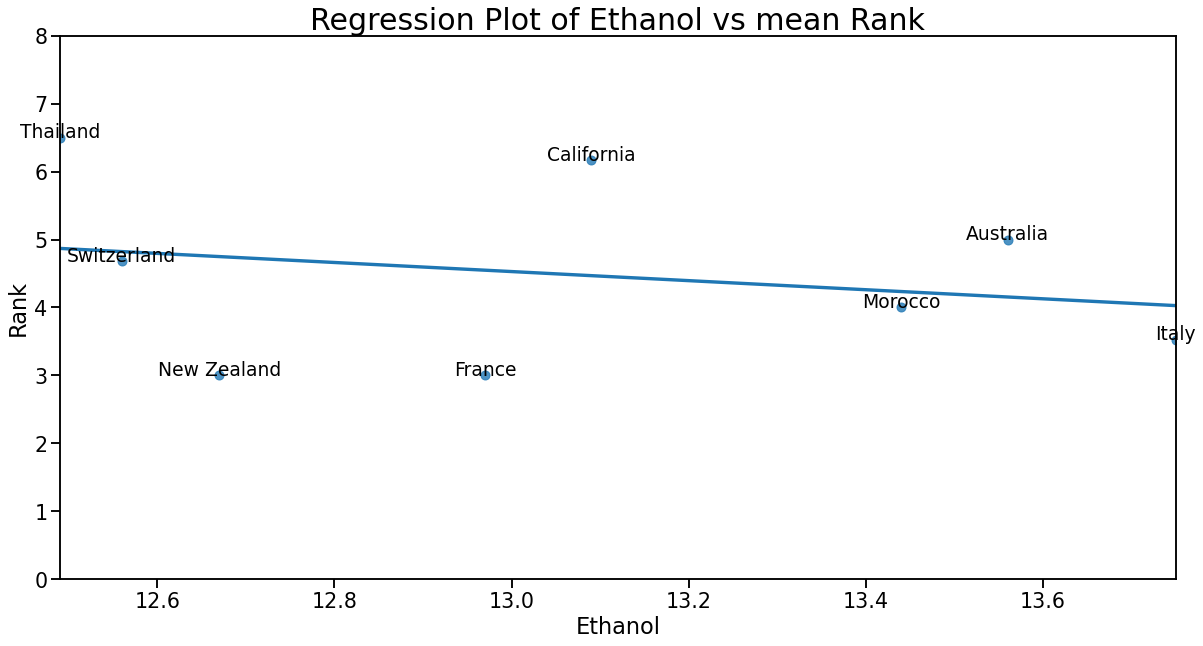

In [24]:
# now we can regress Ethanol vs Rank
sns.set_context("talk", font_scale=1.25)  # set up our aesthetics
fig, ax = plt.subplots(figsize=(20,10))  # and set the figure size
plt.title('Regression Plot of Ethanol vs mean Rank', fontsize='30')  # always a title
ax.set(ylim=(0, 8))  # set the ylim to the same thing for both plots -- makes comparison easier
#plt.plot(df_Country['Ethanol'], intercept + slope*df_Country['Ethanol'],'r', label='y=-0.67x + 13.21 / p=0.57')
sns.regplot(x=df_Country['Ethanol'], y=df_Country['Rank'], ci=None)
for line in range(0,df_Country.shape[0]):
     ax.text(df_Country.Ethanol[line], df_Country.Rank[line], df_Country.index[line], horizontalalignment='center', size='small', color='black')

In [25]:
%%stata -d Nose_df
reg Rank Ethanol
estimates table, star(.05 .01 .001)


      Source |       SS           df       MS      Number of obs   =       150
-------------+----------------------------------   F(1, 148)       =      2.37
       Model |  12.2841224         1  12.2841224   Prob > F        =    0.1258
    Residual |  766.975878       148  5.18226944   R-squared       =    0.0158
-------------+----------------------------------   Adj R-squared   =    0.0091
       Total |      779.26       149  5.22993289   Root MSE        =    2.2765

------------------------------------------------------------------------------
        Rank |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
     Ethanol |  -.6379573   .4143616    -1.54   0.126    -1.456787     .180872
       _cons |   12.79806   5.418867     2.36   0.019     2.089713     23.5064
------------------------------------------------------------------------------

------------------------------
    Variable |    

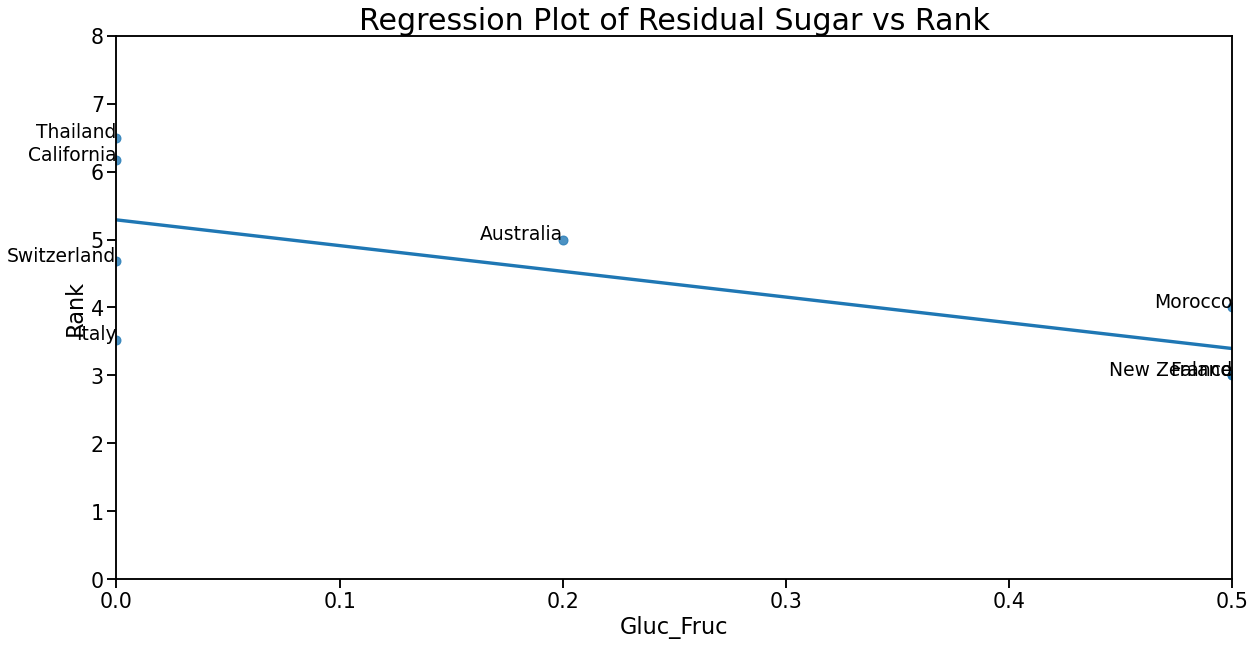

In [26]:
# now we can check the relationship with residual sugar
sns.set_context("talk", font_scale=1.25)  # set up our aesthetics
fig, ax = plt.subplots(figsize=(20,10))  # and set the figure size
plt.title('Regression Plot of Residual Sugar vs Rank', fontsize='30')  # always a title
ax.set(ylim=(0, 8))  # set the ylim to the same thing for both plots -- makes comparison easier
sns.regplot(x=df_Country['Gluc_Fruc'], y=df_Country['Rank'], ci=None)
for line in range(0,df_Country.shape[0]):
     ax.text(df_Country.Gluc_Fruc[line], df_Country.Rank[line], df_Country.index[line], horizontalalignment='right', size='small', color='black')

In [27]:
%%stata -d Nose_df
reg Rank Gluc_Fruc
estimates table, star(.05 .01 .001)


      Source |       SS           df       MS      Number of obs   =       150
-------------+----------------------------------   F(1, 148)       =     24.89
       Model |  112.168004         1  112.168004   Prob > F        =    0.0000
    Residual |  667.091996       148  4.50737835   R-squared       =    0.1439
-------------+----------------------------------   Adj R-squared   =    0.1382
       Total |      779.26       149  5.22993289   Root MSE        =    2.1231

------------------------------------------------------------------------------
        Rank |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
   Gluc_Fruc |  -3.731719     .74806    -4.99   0.000    -5.209977   -2.253461
       _cons |   5.263563   .2366362    22.24   0.000     4.795941    5.731186
------------------------------------------------------------------------------

------------------------------
    Variable |    

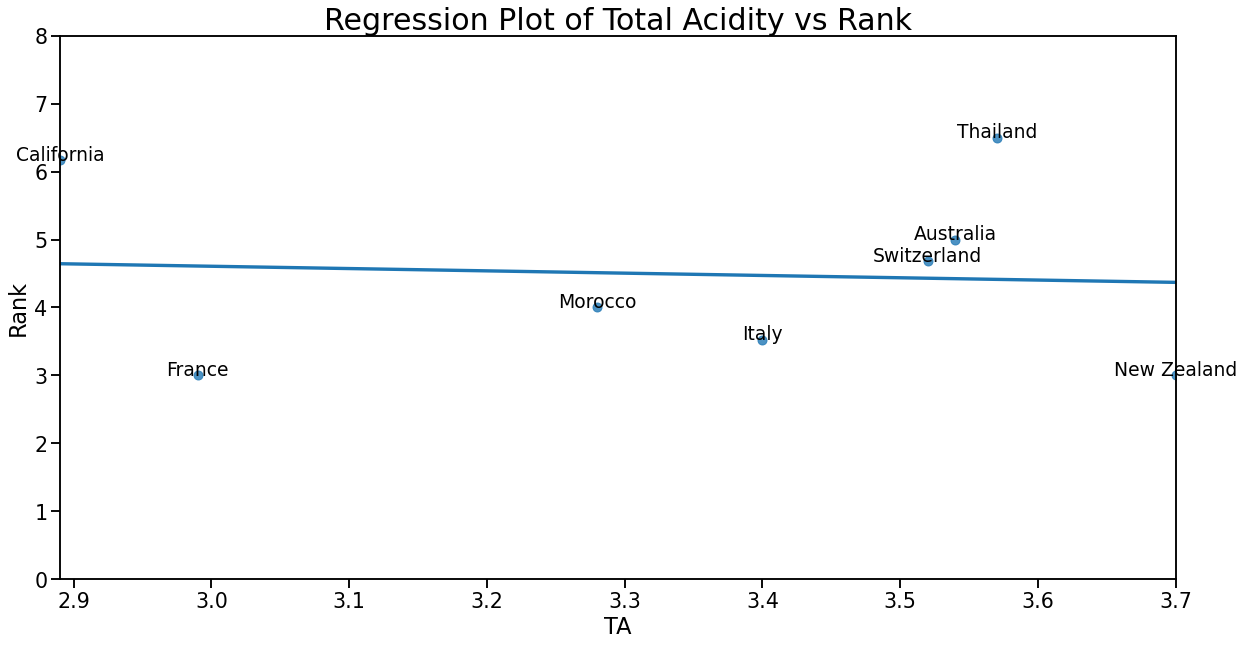

In [28]:
# now we can check the relationship with Total Acidity
sns.set_context("talk", font_scale=1.25)  # set up our aesthetics
fig, ax = plt.subplots(figsize=(20,10))  # and set the figure size
plt.title('Regression Plot of Total Acidity vs Rank', fontsize='30')  # always a title
ax.set(ylim=(0, 8))  # set the ylim to the same thing for both plots -- makes comparison easier
sns.regplot(x=df_Country['TA'], y=df_Country['Rank'], ci=None)
for line in range(0,df_Country.shape[0]):
     ax.text(df_Country.TA[line], df_Country.Rank[line], df_Country.index[line], horizontalalignment='center', size='small', color='black')

In [29]:
%%stata -d Nose_df
reg Rank TA
estimates table, star(.05 .01 .001)


      Source |       SS           df       MS      Number of obs   =       150
-------------+----------------------------------   F(1, 148)       =      0.20
       Model |  1.05397143         1  1.05397143   Prob > F        =    0.6550
    Residual |  778.206029       148  5.25814884   R-squared       =    0.0014
-------------+----------------------------------   Adj R-squared   =   -0.0054
       Total |      779.26       149  5.22993289   Root MSE        =    2.2931

------------------------------------------------------------------------------
        Rank |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
          TA |  -.3121029   .6971076    -0.45   0.655    -1.689673    1.065467
       _cons |   5.509602   2.351837     2.34   0.020     .8620837    10.15712
------------------------------------------------------------------------------

------------------------------
    Variable |    

In [30]:
# this has been interesting but it's time to look at the actual descriptors in the datasets

In [31]:
Nose_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Taster           152 non-null    int64  
 1   Wine             152 non-null    int64  
 2   Country          152 non-null    object 
 3   Price            152 non-null    float64
 4   Ethanol          152 non-null    float64
 5   Gluc_Fruc        152 non-null    float64
 6   TA               152 non-null    float64
 7   pH               152 non-null    float64
 8   AV               152 non-null    float64
 9   Malic_Acid       152 non-null    float64
 10  Lactic_Acid      152 non-null    float64
 11  IPT              152 non-null    int64  
 12  Density          152 non-null    float64
 13  Rank             150 non-null    float64
 14  Country_Guess    152 non-null    object 
 15  Correct_Guess    152 non-null    object 
 16  Nose_Count       152 non-null    int64  
 17  Fruity          

In [32]:
# we can get rid of all columns without values
Nose_pick_df = Nose_df.loc[:, (Nose_df != 0).any(axis=0)]  # 
Nose_pick_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 72 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Taster           152 non-null    int64  
 1   Wine             152 non-null    int64  
 2   Country          152 non-null    object 
 3   Price            152 non-null    float64
 4   Ethanol          152 non-null    float64
 5   Gluc_Fruc        152 non-null    float64
 6   TA               152 non-null    float64
 7   pH               152 non-null    float64
 8   AV               152 non-null    float64
 9   Malic_Acid       152 non-null    float64
 10  Lactic_Acid      152 non-null    float64
 11  IPT              152 non-null    int64  
 12  Density          152 non-null    float64
 13  Rank             150 non-null    float64
 14  Country_Guess    152 non-null    object 
 15  Correct_Guess    152 non-null    object 
 16  Nose_Count       152 non-null    int64  
 17  Fruity          

In [ ]:
sns.pairplot(Nose_pick_df, hue='Wine')